<H1><B>Série temporal de temperaturas da cidade do Recife</B></H>
<H3>Arquivo contendo séries temporais de temperatura para a cidade do Recife. Os registros de temperatura são fornecidos por meses. As últimas colunas são valores médios de acordo com algumas estimativas de cálculo.<H3>
<H3><B>1 - Carregando a base de dados e instalando as bibliotecas necessárias</B></H3>

In [16]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report

# Instalação das dependências
!pip install mlflow pyngrok xgboost optuna 'mlflow[extras]' optuna-integration -q

# Imports de MLFlow e utilidades para Colab
import mlflow
import mlflow.sklearn
import threading
import time
import os
from pyngrok import ngrok

# Classes de modelos e métricas que faltavam
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb # NEW!
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Configuração do MLFlow
mlflow.set_experiment("Previsao_Temperaturas_Recife_Colab_new")

import optuna
from optuna.integration.mlflow import MLflowCallback

url = "https://raw.githubusercontent.com/MichaelTRArruda/dados/refs/heads/main/station_recife.csv"

df = pd.read_csv(url)
df.replace(999.90, np.nan, inplace=True)
df = df.fillna(df.mean()).round(2)
df.rename(columns={'metANN': 'temperatura_media_anual'}, inplace=True)
df.head()

2025/09/28 07:28:21 INFO mlflow.tracking.fluent: Experiment with name 'Previsao_Temperaturas_Recife_Colab_new' does not exist. Creating a new experiment.


,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,D-J-F,M-A-M,J-J-A,S-O-N,temperatura_media_anual
0,1942,26.44,26.64,26.53,26.11,25.39,24.57,23.98,23.90,24.62,25.50,26.03,25.23,26.47,26.02,24.14,25.37,25.50
1,1943,25.73,25.73,26.03,24.83,24.03,23.23,22.33,22.53,23.43,24.73,25.13,25.52,25.56,24.96,22.70,24.43,24.41
2,1944,25.62,25.92,26.22,25.02,24.12,23.42,22.62,21.92,22.82,24.32,25.42,26.02,25.69,25.12,22.65,24.19,24.41
3,1945,26.52,25.52,26.52,25.82,24.32,22.72,22.32,23.02,23.82,24.52,25.52,25.41,26.02,25.55,22.69,24.62,24.72
4,1946,25.51,26.41,25.81,24.61,24.51,23.41,23.41,23.41,23.61,24.41,24.81,25.30,25.78,24.98,23.41,24.28,24.61


<H3><B>2 - Remove colunas vazias</B></H3>

In [17]:
print(df.isnull().sum())

#remove colunas com ao menos 70% de dados ausentes
df = df.dropna(thresh=0.7*len(df), axis=1)

YEAR                       0
JAN                        0
FEB                        0
MAR                        0
APR                        0
MAY                        0
JUN                        0
JUL                        0
AUG                        0
SEP                        0
OCT                        0
NOV                        0
DEC                        0
D-J-F                      0
M-A-M                      0
J-J-A                      0
S-O-N                      0
temperatura_media_anual    0
dtype: int64


<B><H3>3 - gráfico de linha para exibir as temperaturas médias anuais ao longo do tempo</B></H3>

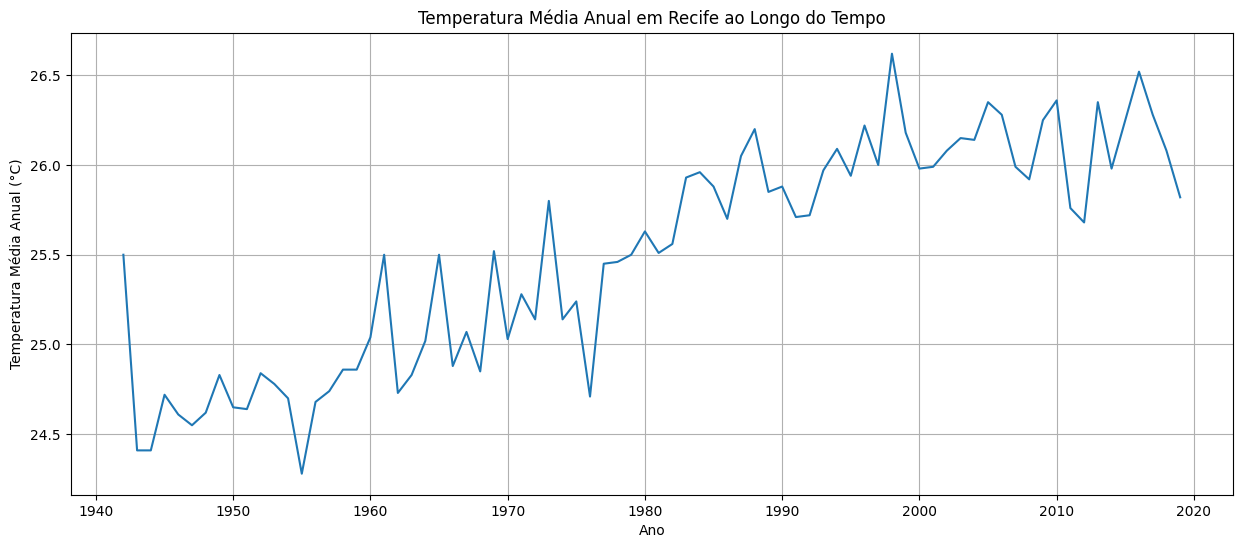

In [18]:
plt.figure(figsize=(15, 6))
plt.plot(df['YEAR'], df['temperatura_media_anual'])
plt.title('Temperatura Média Anual em Recife ao Longo do Tempo')
plt.xlabel('Ano')
plt.ylabel('Temperatura Média Anual (°C)')
plt.grid(True)
plt.show()

<B><H3>4 - Criando uma variável alvo categórica 'categoria_temperatura'</B></H3>

In [19]:
limiar_temp_baixa = df['temperatura_media_anual'].quantile(0.33)
limiar_temp_alta = df['temperatura_media_anual'].quantile(0.66)

def categorizar_temperatura(temp):
    if temp <= limiar_temp_baixa:
        return 'Baixa'
    elif temp >= limiar_temp_alta:
        return 'Alta'
    else:
        return 'Média'

df['categoria_temperatura'] = df['temperatura_media_anual'].apply(categorizar_temperatura)

<B><H3>5 - Definindo as características (features) e o alvo (target)</B></H3>

In [20]:
caracteristicas = df.drop(columns=['YEAR', 'temperatura_media_anual', 'categoria_temperatura'])
alvo = df['categoria_temperatura']

<B><H3>6 - Dividindo os dados em conjuntos de treino e teste</B></H3>

In [21]:
caracteristicas_treino, caracteristicas_teste, alvo_treino, alvo_teste = train_test_split(
    caracteristicas, alvo, test_size=0.3, random_state=42, stratify=alvo
)

print(df[['temperatura_media_anual', 'categoria_temperatura']].head())
print("\nDistribuição de 'categoria_temperatura' no conjunto de treino:")
print(alvo_treino.value_counts())

   temperatura_media_anual categoria_temperatura
0                    25.50                 Média
1                    24.41                 Baixa
2                    24.41                 Baixa
3                    24.72                 Baixa
4                    24.61                 Baixa

Distribuição de 'categoria_temperatura' no conjunto de treino:
categoria_temperatura
Alta     19
Baixa    18
Média    17
Name: count, dtype: int64


<H3><B>7 - OTIMIZAÇÃO AVANÇADA DE HIPERPARÂMETROS E RASTREAMENTO MLFLOW</B></H3>
<H3>Nesta etapa utilizaremos o framework Optuna para realizar uma busca inteligente (TPE Sampler) e automatizada dos hiperparâmetros ideais para o <B>SVC, RandomForestClassifier e Perceptron.</B> O objetivo é maximizar o F1-Score (ponderado) através de validação cruzada.</H3>

<H3>Todo o processo de experimentação, desde cada tentativa de trial do Optuna até o resultado final do melhor modelo, será rastreado e registrado no MLflow. Ao final, avaliaremos os três modelos otimizados no conjunto de teste para determinar o classificador mais robusto para a previsão de temperaturas.</H3>

In [25]:
# Importações de Métricas e Modelos
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score # <-- CORREÇÃO: MIGRADO PARA model_selection
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron

# Importações de Ferramentas
from optuna.integration.mlflow import MLflowCallback
import optuna
import mlflow

# 1. Função objective (inalterada)
def objective(trial, nome_modelo):
    """Define a função que o Optuna tentará otimizar (maximizar o F1-Score CV)."""

    # A) DEFINIÇÃO DO ESPAÇO DE BUSCA (HIPERPARÂMETROS)
    if nome_modelo == 'SVC':
        C = trial.suggest_float('C', 1e-3, 10, log=True)
        kernel = trial.suggest_categorical('kernel', ['rbf', 'linear'])
        max_iter = trial.suggest_int('max_iter', 1000, 10000)

        modelo = SVC(C=C, kernel=kernel, max_iter=max_iter, random_state=42)

    elif nome_modelo == 'RandomForestClassifier':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 3, 15)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

        modelo = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=42,
            n_jobs=-1
        )

    elif nome_modelo == 'Perceptron':
        alpha = trial.suggest_float('alpha', 1e-5, 0.1, log=True)
        penalty = trial.suggest_categorical('penalty', ['l2', 'elasticnet', None])
        max_iter = trial.suggest_int('max_iter', 1000, 10000)

        modelo = Perceptron(alpha=alpha, penalty=penalty, max_iter=max_iter, random_state=42)

    else:
        raise ValueError("Modelo não suportado.")

    # B) AVALIAÇÃO COM VALIDAÇÃO CRUZADA (CV)
    # cross_val_score agora é reconhecido corretamente
    score = cross_val_score(
        modelo,
        caracteristicas_treino,
        alvo_treino,
        cv=5,
        scoring='f1_weighted',
        n_jobs=-1
    )

    f1_score_medio = score.mean()
    trial.set_user_attr('f1_weighted_cv_mean', f1_score_medio)

    return f1_score_medio


# 2. PROCESSO DE OTIMIZAÇÃO PRINCIPAL
algoritmos_para_otimizar = ['SVC', 'RandomForestClassifier', 'Perceptron']
mlflow.set_experiment("Otimizacao_Modelos_Finais_Temperaturas_New")

melhores_modelos_por_algoritmo = {}
melhores_resultados_teste = {}
input_example = caracteristicas_treino[:1]

print("\n--- Otimização de Hiperparâmetros (Optuna) ---")

for nome in algoritmos_para_otimizar:

    # 1. Cria o callback do MLFlow
    mlflow_callback = MLflowCallback(
        tracking_uri=mlflow.get_tracking_uri(),
        metric_name='f1_weighted_cv_mean'
    )

    # 2. Cria o Study
    study = optuna.create_study(direction='maximize')

    # 3. Executa a otimização
    study.optimize(
        lambda trial: objective(trial, nome),
        n_trials=50, # Número de trials (combinações)
        callbacks=[mlflow_callback],
        show_progress_bar=True
    )


    with mlflow.start_run(run_name=f"FINAL_SUMMARY_{nome}_Best_Model") as parent_run:

        # 4. Avalia o Melhor Modelo no Conjunto de Teste
        melhor_params = study.best_params

        # Instancia e treina o melhor modelo com os parâmetros otimizados
        if nome == 'SVC':
            melhor_modelo_treinado = SVC(**melhor_params, random_state=42)
        elif nome == 'RandomForestClassifier':
            melhor_modelo_treinado = RandomForestClassifier(**melhor_params, random_state=42, n_jobs=-1)
        elif nome == 'Perceptron':
            # Garante que o parâmetro max_iter esteja presente, se otimizado
            params_perc = {**melhor_params, 'max_iter': melhor_params.get('max_iter', 1000)}
            melhor_modelo_treinado = Perceptron(**params_perc, random_state=42)

        melhor_modelo_treinado.fit(caracteristicas_treino, alvo_treino)

        # Predição e Cálculo das Métricas de Teste
        alvo_predito_teste = melhor_modelo_treinado.predict(caracteristicas_teste)
        acuracia_teste = accuracy_score(alvo_teste, alvo_predito_teste)
        f1_teste = f1_score(alvo_teste, alvo_predito_teste, average='weighted', zero_division=0)

        # 5. RASTREAMENTO NO MLFLOW (Logando no FINAL_SUMMARY_Run)
        mlflow.log_params(melhor_params)
        mlflow.log_metric("F1_Score_Melhor_CV", study.best_value) # Melhor valor encontrado na CV
        mlflow.log_metric("Acuracia_Teste", acuracia_teste)
        mlflow.log_metric("F1_Teste", f1_teste)

        # Salva o melhor modelo treinado
        mlflow.sklearn.log_model(
            melhor_modelo_treinado,
            f"modelo_optuna_otimizado_{nome.lower()}",
            input_example=input_example
        )

        # 6. Armazena o melhor resultado para o Item 8
        melhores_modelos_por_algoritmo[nome] = melhor_modelo_treinado
        melhores_resultados_teste[nome] = {
            'Acuracia_Teste': acuracia_teste,
            'F1_Teste': f1_teste,
            'Melhores_Params': melhor_params
        }

        print(f"✅ {nome} Otimizado:")
        print(f"   -> Melhor F1-Score CV: {study.best_value:.4f}")
        print(f"   -> Parâmetros Otimizados: {melhor_params}")
        print(f"   -> F1-Score no Teste: {f1_teste:.4f}")
        print("-" * 50)


# 7. SELEÇÃO FINAL
print("\n--- Seleção do Melhor Modelo Geral ---")
melhor_modelo_geral = None
melhor_f1 = -1

for nome, resultado in melhores_resultados_teste.items():
    if resultado['F1_Teste'] > melhor_f1:
        melhor_f1 = resultado['F1_Teste']
        melhor_modelo_geral = nome

print(f"\nO MELHOR MODELO GERAL (com base no F1-Score do Teste) é o: {melhor_modelo_geral}")
print(f"F1-Score no Conjunto de Teste: {melhor_f1:.4f}")
print(f"Parâmetros: {melhores_resultados_teste[melhor_modelo_geral]['Melhores_Params']}")

2025/09/28 07:30:05 INFO mlflow.tracking.fluent: Experiment with name 'Otimizacao_Modelos_Finais_Temperaturas_New' does not exist. Creating a new experiment.
/tmp/ipython-input-1801647911.py:78: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflow_callback = MLflowCallback(
[I 2025-09-28 07:30:06,001] A new study created in memory with name: no-name-2ff6a1a6-d65e-4b97-841b-dffbda456981



--- Otimização de Hiperparâmetros (Optuna) ---


  0%|          | 0/50 [00:00<?, ?it/s]

2025/09/28 07:30:09 INFO mlflow.tracking.fluent: Experiment with name 'no-name-2ff6a1a6-d65e-4b97-841b-dffbda456981' does not exist. Creating a new experiment.


[I 2025-09-28 07:30:09,914] Trial 0 finished with value: 0.3093084693084693 and parameters: {'C': 0.0050267491410949825, 'kernel': 'rbf', 'max_iter': 3438}. Best is trial 0 with value: 0.3093084693084693.
[I 2025-09-28 07:30:10,044] Trial 1 finished with value: 0.8782323232323233 and parameters: {'C': 0.011322265625486253, 'kernel': 'linear', 'max_iter': 9400}. Best is trial 1 with value: 0.8782323232323233.
[I 2025-09-28 07:30:10,170] Trial 2 finished with value: 0.8218528138528137 and parameters: {'C': 0.24767491194831698, 'kernel': 'linear', 'max_iter': 6172}. Best is trial 1 with value: 0.8782323232323233.
[I 2025-09-28 07:30:10,271] Trial 3 finished with value: 0.5752800734618917 and parameters: {'C': 0.0030996478299135824, 'kernel': 'linear', 'max_iter': 9973}. Best is trial 1 with value: 0.8782323232323233.
[I 2025-09-28 07:30:10,376] Trial 4 finished with value: 0.8775757575757577 and parameters: {'C': 9.84804216739413, 'kernel': 'linear', 'max_iter': 3774}. Best is trial 1 wit

2025/09/28 07:30:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[I 2025-09-28 07:30:14,104] Trial 49 finished with value: 0.3093084693084693 and parameters: {'C': 0.0036399334146816303, 'kernel': 'rbf', 'max_iter': 8710}. Best is trial 7 with value: 0.941968253968254.


/tmp/ipython-input-1801647911.py:78: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflow_callback = MLflowCallback(
[I 2025-09-28 07:30:18,123] A new study created in memory with name: no-name-d4077bec-8af0-4975-acba-e2c14f53bead


✅ SVC Otimizado:
   -> Melhor F1-Score CV: 0.9420
   -> Parâmetros Otimizados: {'C': 0.27345857529487566, 'kernel': 'rbf', 'max_iter': 8758}
   -> F1-Score no Teste: 0.9582
--------------------------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

2025/09/28 07:30:18 INFO mlflow.tracking.fluent: Experiment with name 'no-name-d4077bec-8af0-4975-acba-e2c14f53bead' does not exist. Creating a new experiment.


[I 2025-09-28 07:30:18,687] Trial 0 finished with value: 0.8812265512265511 and parameters: {'n_estimators': 50, 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8812265512265511.
[I 2025-09-28 07:30:19,653] Trial 1 finished with value: 0.8812265512265511 and parameters: {'n_estimators': 105, 'max_depth': 12, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8812265512265511.
[I 2025-09-28 07:30:21,910] Trial 2 finished with value: 0.9009235209235211 and parameters: {'n_estimators': 210, 'max_depth': 13, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.9009235209235211.
[I 2025-09-28 07:30:24,513] Trial 3 finished with value: 0.9009235209235211 and parameters: {'n_estimators': 196, 'max_depth': 13, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.9009235209235211.
[I 2025-09-28 07:30:25,031] Trial 4 finished with value: 0.8812265512265511 and parameters: {'n_estimators': 51, 'max_depth': 11, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.900923

2025/09/28 07:31:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/tmp/ipython-input-1801647911.py:78: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflow_callback = MLflowCallback(
[I 2025-09-28 07:31:58,610] A new study created in memory with name: no-name-55765a69-8b22-41ea-aa0c-f7402f85379c


✅ RandomForestClassifier Otimizado:
   -> Melhor F1-Score CV: 0.9009
   -> Parâmetros Otimizados: {'n_estimators': 210, 'max_depth': 13, 'min_samples_leaf': 5}
   -> F1-Score no Teste: 0.8704
--------------------------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

2025/09/28 07:31:58 INFO mlflow.tracking.fluent: Experiment with name 'no-name-55765a69-8b22-41ea-aa0c-f7402f85379c' does not exist. Creating a new experiment.


[I 2025-09-28 07:31:58,726] Trial 0 finished with value: 0.16743256743256746 and parameters: {'alpha': 5.754100361894293e-05, 'penalty': 'elasticnet', 'max_iter': 9144}. Best is trial 0 with value: 0.16743256743256746.
[I 2025-09-28 07:31:58,874] Trial 1 finished with value: 0.16743256743256746 and parameters: {'alpha': 0.00021353312012171416, 'penalty': None, 'max_iter': 2639}. Best is trial 0 with value: 0.16743256743256746.
[I 2025-09-28 07:31:59,014] Trial 2 finished with value: 0.16743256743256746 and parameters: {'alpha': 0.00017569418147424395, 'penalty': None, 'max_iter': 4421}. Best is trial 0 with value: 0.16743256743256746.
[I 2025-09-28 07:31:59,143] Trial 3 finished with value: 0.16743256743256746 and parameters: {'alpha': 8.686890733681742e-05, 'penalty': 'elasticnet', 'max_iter': 2841}. Best is trial 0 with value: 0.16743256743256746.
[I 2025-09-28 07:31:59,298] Trial 4 finished with value: 0.16743256743256746 and parameters: {'alpha': 0.01742972613160222, 'penalty': 'l2

2025/09/28 07:32:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[I 2025-09-28 07:32:03,419] Trial 49 finished with value: 0.16743256743256746 and parameters: {'alpha': 0.0004021171738555525, 'penalty': None, 'max_iter': 9012}. Best is trial 17 with value: 0.2343822843822844.
✅ Perceptron Otimizado:
   -> Melhor F1-Score CV: 0.2344
   -> Parâmetros Otimizados: {'alpha': 0.0006325145910658214, 'penalty': 'elasticnet', 'max_iter': 5531}
   -> F1-Score no Teste: 0.1667
--------------------------------------------------

--- Seleção do Melhor Modelo Geral ---

O MELHOR MODELO GERAL (com base no F1-Score do Teste) é o: SVC
F1-Score no Conjunto de Teste: 0.9582
Parâmetros: {'C': 0.27345857529487566, 'kernel': 'rbf', 'max_iter': 8758}


<H3><B>8 - ANÁLISE DE DESEMPENHO E ERROS (MATRIZES E RELATÓRIOS)</B></H3>
<H3>Para além das métricas resumidas, esta seção foca em uma análise diagnóstica dos três modelos otimizados <B>(SVC, RandomForestClassifier e Perceptron)</B> no conjunto de teste.</H3>

<H3><B>Matrizes de Confusão:</B> Visualizaremos como cada modelo está realizando as classificações, identificando graficamente a taxa de acerto por categoria e os tipos de erros mais comuns (por exemplo, quando uma temperatura 'Média' é confundida com 'Baixa').</H3>

<H3><B>Relatórios de Classificação:</B> Analisaremos as métricas essenciais por classe <B>(Precisão, Recall e F1-Score)</B> para obter uma visão clara do desempenho do modelo em cada categoria de temperatura ('Baixa', 'Média', 'Alta'). Esta análise detalhada é fundamental para entender a qualidade preditiva em cenários desbalanceados.</H3>


AVALIAÇÃO DETALHADA DOS MODELOS OTIMIZADOS


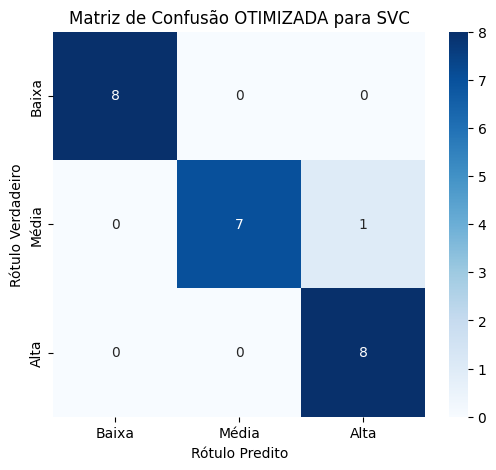


Relatório de Classificação OTIMIZADO para SVC:

              precision    recall  f1-score   support

        Alta       0.89      1.00      0.94         8
       Baixa       1.00      1.00      1.00         8
       Média       1.00      0.88      0.93         8

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24

--------------------------------------------------


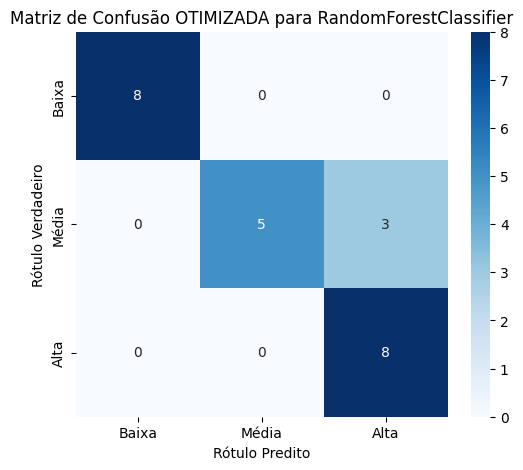


Relatório de Classificação OTIMIZADO para RandomForestClassifier:

              precision    recall  f1-score   support

        Alta       0.73      1.00      0.84         8
       Baixa       1.00      1.00      1.00         8
       Média       1.00      0.62      0.77         8

    accuracy                           0.88        24
   macro avg       0.91      0.88      0.87        24
weighted avg       0.91      0.88      0.87        24

--------------------------------------------------


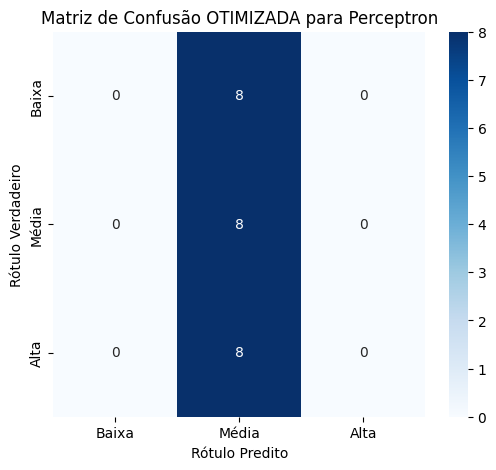


Relatório de Classificação OTIMIZADO para Perceptron:

              precision    recall  f1-score   support

        Alta       0.00      0.00      0.00         8
       Baixa       0.00      0.00      0.00         8
       Média       0.33      1.00      0.50         8

    accuracy                           0.33        24
   macro avg       0.11      0.33      0.17        24
weighted avg       0.11      0.33      0.17        24

--------------------------------------------------


In [26]:
print("\n" + "="*70)
print("AVALIAÇÃO DETALHADA DOS MODELOS OTIMIZADOS")
print("="*70)

for nome, modelo_otimizado in melhores_modelos_por_algoritmo.items():

    # 1. Predição no conjunto de teste
    alvo_predito = modelo_otimizado.predict(caracteristicas_teste)

    # 2. Matriz de Confusão
    matriz_confusao = confusion_matrix(alvo_teste, alvo_predito, labels=['Baixa', 'Média', 'Alta'])

    plt.figure(figsize=(6, 5))
    sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Baixa', 'Média', 'Alta'], yticklabels=['Baixa', 'Média', 'Alta'])
    plt.title(f'Matriz de Confusão OTIMIZADA para {nome}')
    plt.xlabel('Rótulo Predito')
    plt.ylabel('Rótulo Verdadeiro')
    plt.show()

    # 3. Relatório de Classificação
    print(f"\nRelatório de Classificação OTIMIZADO para {nome}:\n")
    print(classification_report(alvo_teste, alvo_predito, zero_division=0))
    print("-" * 50)

<H3><B>9 - COMPARAÇÃO FINAL E SELEÇÃO DO MODELO VENCEDOR
</B></H3>

<H3>Esta seção apresenta a síntese executiva do processo de otimização. Após a análise detalhada das Matrizes de Confusão (Item 8.1), agora consolidamos os resultados para a tomada de decisão final.</H3>

<H3>Iremos:</H3>

<H3><B>Comparar numericamente</B> os scores de <B>Acurácia</B> e <B>F1-Score</B> (no conjunto de teste) dos três modelos otimizados.</H3>

<H3><B>Visualizar graficamente</B> essa comparação, destacando de forma clara qual algoritmo atingiu a performance máxima.</H3>

<H3>O resultado desta comparação definirá o <B>modelo final</B> a ser escolhido como solução mais robusta para a classificação das categorias de temperatura ('Baixa', 'Média', 'Alta').</H3>



--- Comparação Final dos Modelos Otimizados (Acurácia e F1-Score no Teste) ---
                       Acuracia_Teste  F1_Teste
SVC                          0.958333   0.95817
RandomForestClassifier          0.875  0.870445
Perceptron                   0.333333  0.166667


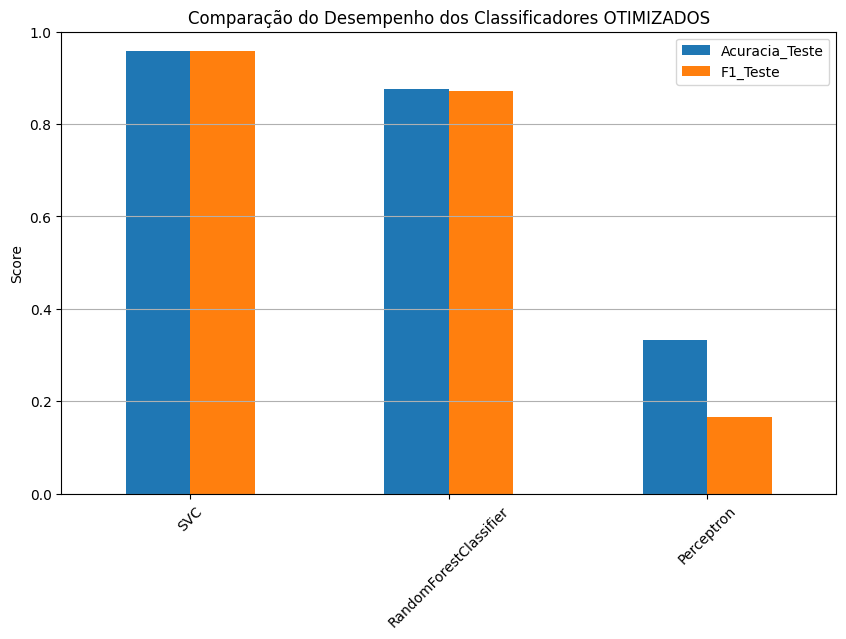

In [27]:
# Importa pandas e matplotlib, caso ainda não estejam importados na célula
import pandas as pd
import matplotlib.pyplot as plt

# 1. Cria o DataFrame de comparação
# Usamos o dicionário preenchido pelo bloco de otimização
df_comparacao_otimizada = pd.DataFrame(melhores_resultados_teste).T

# Remove a coluna de Parâmetros para deixar a tabela de métricas mais limpa
df_comparacao_metricas = df_comparacao_otimizada.drop(columns=['Melhores_Params'])

print("\n--- Comparação Final dos Modelos Otimizados (Acurácia e F1-Score no Teste) ---")
print(df_comparacao_metricas.round(4))

# 2. Visualiza a comparação
df_comparacao_metricas.plot(kind='bar', figsize=(10, 6))
plt.title('Comparação do Desempenho dos Classificadores OTIMIZADOS')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

<H3><B>10 - ACESSO À UI DO MLFLOW: PORTAL DE RASTREAMENTO DO PROJETO</B></H3>
<H3>Esta é a etapa final para acessar o painel de controle do seu projeto de MLOps.</H3>

<H3>Utilizamos o <B>MLflow Tracking</B> para registrar cada detalhe dos experimentos (modelos, hiperparâmetros e métricas). Agora, usaremos o <B>ngrok</B> para criar um túnel público seguro, permitindo o acesso à <B>Interface do Usuário (UI) do MLflow</B> diretamente do seu navegador.</H3>

<H3>A UI do MLflow permitirá:</H3>

<H3><B>Comparar visualmente</B> os resultados de todos os trials do Optuna.</H3>

<H3><B>Inspecionar</B> os parâmetros e as métricas finais de cada modelo otimizado.</H3>

<H3><B>Acessar e baixar</B> os modelos finais salvos (artefatos) prontos para a produção ou deployment.</H3>

In [28]:
import os
import threading
import time
import mlflow
from pyngrok import ngrok
ngrok_token = "33IMfliEaQEel9oE5pJph8CWCtP_3vZEsSsrSvWb26PgP2p1A"

try:
    ngrok.set_auth_token(ngrok_token)
except Exception:
    print("⚠️ ERRO: O token ngrok não foi configurado ou é inválido. O acesso pode falhar.")

# 1. Define o caminho de rastreamento local do Colab
tracking_uri = "file:///content/mlruns"
mlflow.set_tracking_uri(tracking_uri)

# 2. Função para rodar o servidor MLFlow em segundo plano
def run_mlflow_ui():
    # Isso inicia o servidor na porta 5000 (padrão)
    # Redirecionamos a saída para /dev/null para evitar poluir o notebook com logs do servidor
    os.system("mlflow ui --port 5000 > /dev/null 2>&1")

print("Iniciando servidor MLFlow...")
# Inicia o servidor em uma thread separada para não bloquear o notebook
threading.Thread(target=run_mlflow_ui, daemon=True).start()
time.sleep(5) # Espera 5 segundos para o servidor iniciar

# 3. Cria o túnel público (link) com ngrok
try:
    public_url = ngrok.connect(addr="5000", proto="http")

    print("\n" + "="*70)
    print("✅ OK! MLFLOW UI ESTÁ DISPONÍVEL NESTE LINK:")
    print(public_url)
    print("="*70 + "\n")

except Exception as e:
    print(f"❌ ERRO FATAL ao criar o túnel ngrok. Verifique se o token foi configurado: {e}")

Iniciando servidor MLFlow...

✅ OK! MLFLOW UI ESTÁ DISPONÍVEL NESTE LINK:
NgrokTunnel: "https://kian-unabating-kyleigh.ngrok-free.dev" -> "http://localhost:5000"



**Conclusão da Análise de Desempenho: Olhando Além da Acurácia**

Nossa análise de resultados transcende as métricas simples, como a acurácia geral, para garantir uma avaliação completa e robusta do desempenho de nossos classificadores otimizados. Para isso, focamos em duas ferramentas diagnósticas essenciais: a **Matriz de Confusão** e o **Relatório de Classificação**.

1. **Matriz de Confusão (O Diagnóstico Visual)**
A **Matriz de Confusão** oferece uma imagem visual e direta do desempenho de cada modelo. Ela resume onde as predições estão certas e, mais importante, onde estão erradas.

Cada linha representa a **classe real** da temperatura (o que realmente aconteceu).

Cada coluna representa a **classe predita** pelo modelo.

Ao examinar a matriz, podemos identificar padrões de erro, como um modelo que sistematicamente confunde temperaturas na categoria **"Baixa"** com **"Média"**, permitindo que ajustemos nossa estratégia de análise.

2. **Relatório de Classificação (O Detalhamento por Classe)**
O **Relatório de Classificação** complementa a matriz ao fornecer um detalhamento preciso do desempenho do modelo para cada categoria de temperatura ('Baixa', 'Média', 'Alta').

**Precisão:** Mede a qualidade das predições positivas, ou seja, quantas das previsões para uma classe específica estavam, de fato, corretas. Uma alta precisão significa uma baixa taxa de falsos positivos.

**Recordação (Sensibilidade)**: Mede a capacidade do modelo de encontrar todas as amostras positivas reais. Um alto recall indica uma baixa taxa de falsos negativos.

**Pontuação F1**: Sendo a média harmônica de Precisão e Recall, é a métrica ideal para avaliar o desempenho em cenários com classes desbalanceadas, onde é crucial equilibrar falsos positivos e falsos negativos.

**Suporte**: Indica o número real de ocorrências daquela classe no conjunto de dados, fornecendo contexto ao valor das outras métricas.

Ao desmembrar o desempenho classe por classe, obtemos uma compreensão profunda dos pontos fortes e fracos de nossos modelos. Isso evita a armadilha de confiar em uma alta acurácia geral, que pode mascarar um desempenho ruim na previsão de uma categoria de temperatura menos frequente.